# 1. Linear regression with errorbars in both axis

In this notebook I will show you how to perform linear regression with errorbars using different packages

FIRST SCIPY

In [ ]:
# import the packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr

In [2]:
plt.rcParams['legend.numpoints']=1
plt.rcParams['xtick.major.size'] = 11
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 11
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.visible']=True #See minor tick
plt.rcParams['text.usetex']=True #use Latex
plt.rcParams['axes.linewidth']=2 #width axes
plt.rcParams['axes.labelsize']=25 #
plt.rcParams['ytick.labelsize']=22 #fontsize of tick labels
plt.rcParams['xtick.labelsize']=22 #fontsize of tick labels
plt.rcParams['ytick.direction']='inout' ## direction: in, out, or inout
plt.rcParams['xtick.direction']='inout' ## direction: in, out, or inout

plt.rcParams['xtick.major.top']=True #draw x axis top major ticks
plt.rcParams['xtick.major.bottom']=True #draw x axis bottom major ticks
plt.rcParams['xtick.minor.top']=True ## draw x axis top minor ticks
plt.rcParams['xtick.minor.bottom']=True #draw x axis bottom minor ticks

plt.rcParams['ytick.major.left']=True #draw y axis left major ticks
plt.rcParams['ytick.major.right']=True #draw y axis right major ticks
plt.rcParams['ytick.minor.left']=True ## draw y axis left minor ticks
plt.rcParams['ytick.minor.right']=True #draw y axis right minor ticks


plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize']=22
plt.rcParams['figure.titlesize']=22

plt.rcParams['text.latex.preamble']=[r'\boldmath']

Text(0,0.5,'\\textbf{Y}')

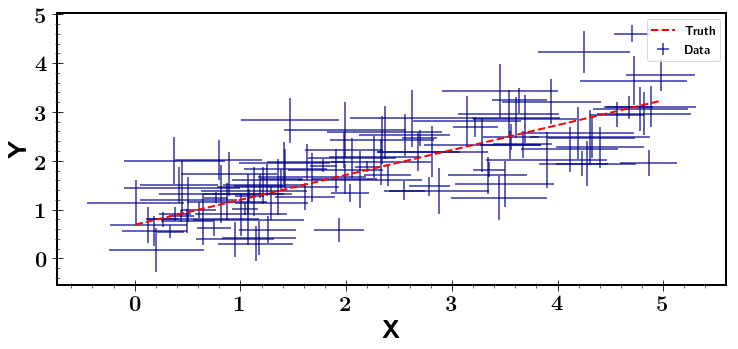

In [38]:
#First we generate data
# Choose the true parameters for the linear regression.
a_true = 0.51
b_true =0.69
true_val=[a_true,b_true]
N_pt = 100
X_data = np.sort(5*np.random.rand(N_pt))
Y_data=(a_true*X_data+b_true) 
yerr = 0.1+0.5*np.random.rand(N_pt)
xerr = yerr/5
Y_data += np.abs(0.2*Y_data) * np.random.randn(N_pt)
Y_data += yerr * np.random.randn(N_pt)

fig,ax1 = plt.subplots(figsize=(12,5), facecolor='w', edgecolor='k')
ax1.errorbar(X_data, Y_data, xerr=yerr,yerr=yerr,color='darkblue',markerfacecolor='darkblue',markeredgecolor='darkblue',ms=10,mew=2,alpha=0.8,zorder=1,linestyle='None',label=r'\textbf{Data}')
ax1.plot(X_data,X_data*a_true+b_true,'r--',linewidth=2,label=r'\textbf{Truth}')
ax1.legend(loc=0,title='',markerscale=0.5,ncol=1,prop={'size':12})
ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')

In [39]:
from scipy.odr import *
# Orthogonal distance regression
# Define a function to fit the data with.
def linear_func(p, x):
    a, b = p
    return a*np.array(x) + b
linear_model = Model(linear_func) # Create a model for fitting
data_fit = RealData(X_data,Y_data,sx=xerr,sy=yerr)
odr_data = ODR(data_fit, linear_model, beta0=[50, 100])
odr_data.set_job(fit_type=0) #fit_type=0 full ODR, 2 least squares optimisation

res_odr = odr_data.run() # Run the regression.
print(f'y = {res_odr.beta[0]:.2f} x + {res_odr.beta[1]:.2f}')


y = 0.54 x + 0.61


In [40]:
#Maximum likelihood
from scipy.optimize import minimize
def log_likelihood(p, x,y,errx,erry):
    # Residuals function for data with errors in both coordinates
    a, b = p
    model=a*x+b
    sigma2 = a*errx**2 + erry**2
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))
                 
nll = lambda *args: -log_likelihood(*args)
bnds = ((0, 100), (0, 100))
res_mini= minimize(nll, [50,100],bounds=bnds,args=(X_data,Y_data,xerr,yerr),method='L-BFGS-B')
if res_mini['success']==True:
    
    print(f'y = %s x + %s'%(round(res_mini['x'][0],2),round(res_mini['x'][1],2)))
else:
    print('Success False')



y = 0.54 x + 0.61


Text(0,0.5,'\\textbf{Y}')

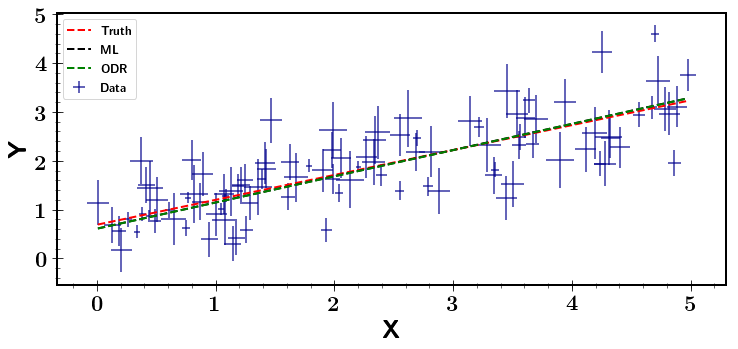

In [41]:
fig,ax1 = plt.subplots(figsize=(12,5), facecolor='w', edgecolor='k')
ax1.errorbar(X_data, Y_data, xerr=xerr,yerr=yerr,color='darkblue',markerfacecolor='darkblue',markeredgecolor='darkblue',ms=10,mew=2,alpha=0.8,zorder=1,linestyle='None',label=r'\textbf{Data}')
ax1.plot(X_data,X_data*a_true+b_true,'r--',linewidth=2,label=r'\textbf{Truth}')
ax1.plot(X_data,X_data*res_odr.beta[0]+res_mini['x'][1],'k--',linewidth=2,label=r'\textbf{ML}')
ax1.plot(X_data,X_data*res_odr.beta[0]+res_odr.beta[1],'g--',linewidth=2,label=r'\textbf{ODR}')
ax1.legend(loc=0,title='',markerscale=0.5,ncol=1,prop={'size':12})
ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')

In [42]:
import emcee


#Define the prior
def log_prior(p):
    a,b = p
    if (-5.0<a<5.0) and (-5.0<b<5.0):
        return 0.0
    return -np.inf

#log probability function
def log_probability(p, x, y,xerr, yerr):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(p, x, y,xerr, yerr)

#Let's run the MCMC
nwalkers, ndim = 400,2
# We start around tiny Gaussian ball around the maximum likelihood result
pos = [res_mini['x'] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(X_data,Y_data,xerr,yerr))
sampler.run_mcmc(pos, 1000)#, progress=True);


(array([[ 0.52389929,  0.64259053],
        [ 0.53520242,  0.61100227],
        [ 0.50914569,  0.64243648],
        [ 0.50481972,  0.65129248],
        [ 0.54125914,  0.52187646],
        [ 0.53467654,  0.60938609],
        [ 0.5448138 ,  0.59866941],
        [ 0.51681715,  0.60955867],
        [ 0.54976949,  0.58111489],
        [ 0.52472873,  0.63790597],
        [ 0.5164092 ,  0.66347801],
        [ 0.51891491,  0.64247159],
        [ 0.56989341,  0.56319879],
        [ 0.54028455,  0.60693102],
        [ 0.52306835,  0.65166178],
        [ 0.53199345,  0.56261662],
        [ 0.54156182,  0.57655533],
        [ 0.54588695,  0.56010139],
        [ 0.51775516,  0.66360986],
        [ 0.54632429,  0.57715924],
        [ 0.51796756,  0.62625828],
        [ 0.50147304,  0.68871001],
        [ 0.53823601,  0.59939705],
        [ 0.54705811,  0.57707004],
        [ 0.54413296,  0.63302173],
        [ 0.55095302,  0.60356376],
        [ 0.53192836,  0.6390639 ],
        [ 0.51079094,  0.645

Mean acceptance fraction:0.720


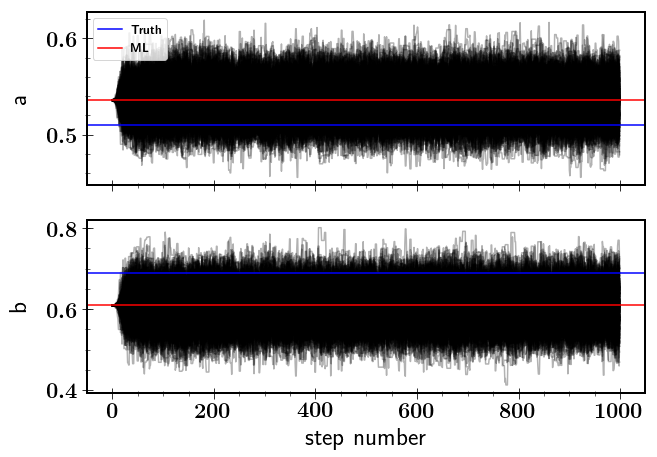

In [43]:
# Let's see if the parameters converge
samples = sampler.chain.reshape((-1,ndim))
#nburns=50
#samples=samples[:, nburns:,:]
print("Mean acceptance fraction:{0:.3f}".format(np.mean(sampler.acceptance_fraction)))
labels = ['a', 'b']
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    
    ax.plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3)
    ax.axhline(true_val[i], color='blue',label=r'\textbf{Truth}')
    ax.axhline(res_mini['x'][i], color='red',label=r'\textbf{ML}')
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
axes[0].legend(loc=0,title='',markerscale=0.5,ncol=1,prop={'size':12})

As seen in this figure, the walkers start in small distributions around the maximum likelihood values (red lines) and start exploring the full posterior distribution. After < 50 steps, the samples seem pretty well “burnt-in”.

In [44]:
# We can remove the first steps
nburns=50
samples=sampler.chain[:, nburns:, :].reshape((-1,ndim))

Let's have a look at the corner plot.
The corner plot shows all the one and two dimensional projections of the posterior probability distributions of your parameters

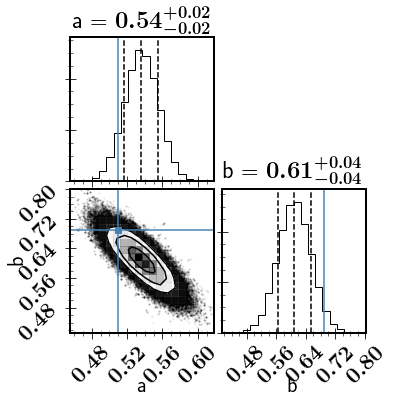

In [45]:
import corner
fig=corner.corner(samples,labels=['a','b'],label_kwargs={"fontsize": 22,"fontweight":'bold'},quantiles=[0.16, 0.5, 0.84],show_titles=True,truths=[a_true, b_true] ,title_kwargs={"fontsize": 24,"fontweight":'bold'})

Finally, we can also plot the projection of all results into the space of the observed data.

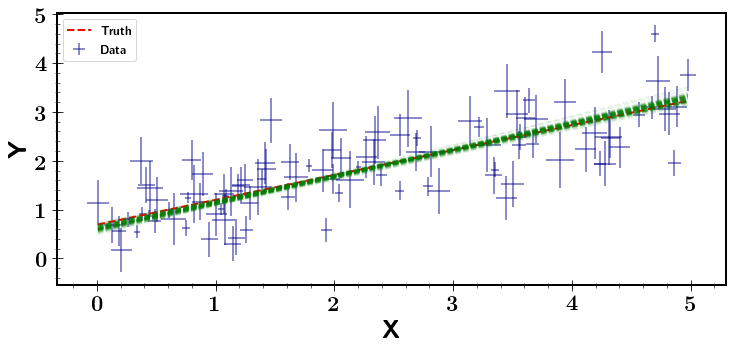

In [46]:
fig,ax1 = plt.subplots(figsize=(12,5), facecolor='w', edgecolor='k')

inds = np.random.randint(len(samples), size=100) # we only plot 50 random slopes
for ind in inds:
    sample = samples[ind]
    ax1.plot(X_data, X_data*sample[0]+sample[1], 'g--', alpha=0.1,zorder=2)

ax1.errorbar(X_data, Y_data, xerr=xerr,yerr=yerr,color='darkblue',markerfacecolor='darkblue',markeredgecolor='darkblue',ms=10,mew=2,alpha=0.6,zorder=1,linestyle='None',label=r'\textbf{Data}')
ax1.plot(X_data,X_data*a_true+b_true,'r--',linewidth=2,label=r'\textbf{Truth}',zorder=1)
ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=0,title='',markerscale=0.5,ncol=1,prop={'size':12})


In [48]:
a_MC,b_MC= map(lambda v: (v[1], v[2]-v[1],v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
from IPython.display import display, Math
txt_a = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt_a = txt_a.format(a_MC[0], a_MC[1], a_MC[2], 'a')
display(Math(txt_a))

txt_b = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt_b = txt_b.format(b_MC[0], b_MC[1], b_MC[2], 'b')
display(Math(txt_b))

<IPython.core.display.Math object>

<IPython.core.display.Math object>